In [74]:
import FinanceDataReader as fdr

In [75]:
import pandas as pd
import numpy as np
import os
import os.path as osp
import datetime
import shutil
import matplotlib.pyplot as plt

In [76]:
def get_name(symbol, market="KRX"):
    root = "dataset/stock_list"
    
    today = datetime.datetime.now()
    today = datetime.datetime.strftime(today, "%Y_%m_%d")
    
    filename = "stock_list_" + today + ".xlsx"
    save_path = osp.join(root, filename)
    
    if not osp.isfile(save_path):
        if osp.exists(root):
            shutil.rmtree(root)
        os.mkdir(root)
        df = fdr.StockListing("KRX")
        df.set_index("Symbol", inplace=True)
        name = df.loc["060310", "Name"]
        df.to_excel(save_path)
    
    else:
        df = pd.read_excel(save_path, index_col="Symbol")
        name = df.loc[symbol, "Name"]
        
    return name

In [77]:
def get_exists_excel(symbol, start_date, end_date):
    root = "dataset"
    filename = "_".join([symbol, start_date.replace("-", "_"), end_date.replace("-", "_")]) + ".xlsx"
    save_path = osp.join(root, filename)
    
    if osp.isfile(save_path):
        is_exsists = True
        df = pd.read_excel(save_path, index_col="Date")
        
    else:
        is_exsists = False
        df = None
        
    return is_exsists, df

In [78]:
def save_excel(df, symbol, start_date, end_date):
    if end_date is None:
        end_date = datetime.datetime.now()
        end_date = datetime.datetime.strftime(end_date, "%Y-%m-%d")
        
    root = "dataset"
    if not osp.exists(root):
        os.mkdir(root)
        
    filename = "_".join([symbol, start_date.replace("-", "_"), end_date.replace("-", "_")]) + ".xlsx"
    save_path = osp.join(root, filename)
    df.to_excel(save_path)

In [140]:
def get_bollinger_band_back_testing_by_num(
    symbol:str="005930", 
    start_date:str=None, 
    end_date:str=None, 
    market:str="KRX", 
    num_buy:int=1,
    fig_save_path:str=None):
    """
        볼린저 밴드: 
        중심선 = day일 종가 이동평균선 (defalt day=20)
        상한선 = 중심선 + alpha*(day일 종가 표준편차) (defalt day=20, defalt alpha=2)
        하한선 = 중심선 - alpha*(day일 종가 표준편차) (defalt day=20, defalt alpha=2)
        
        볼린저 밴드 하한선에 닿으면 지정된 한달 매수 수량에 맞게 매수를 진행.
        만약, 하한선에 닿지 않으면 다음 달로 이월하여 매수를 진행.
        
        symbol: 종목번호 혹은 종목티커
        start_date: 조회할 시작 날짜 (입력 안할 시 오늘로부터 30일 이전으로 설정됨)
        start_date: 조회할 끝 날짜 (입력 안할 시 오늘로 설정됨)
        market: KRX (KOSPI, KODAQ, KONEX), NASDAQ, NYSE, AMEX, S&P 500
        num_buy: 한달 매수 수량
        fig_save_path: 그래프 저장 경로 (확장자명은 생략)
    """
    name = get_name(symbol, market)
    
    if start_date is None:
        start_date = datetime.datetime.now()
        start_date = start_date - datetime.timedelta(days=30)
        start_date = datetime.datetime.strftime(start_date, "%Y-%m-%d")
        
    if end_date is None:
        end_date = datetime.datetime.now()
        end_date = datetime.datetime.strftime(end_date, "%Y-%m-%d")
        
    is_exsists, df = get_exists_excel(symbol, start_date, end_date)
    if not is_exsists:
        df = fdr.DataReader(symbol, start=start_date, end=end_date)
        save_excel(df, symbol, start_date, end_date)
        
    df["M20"] = df["Close"].rolling(20).mean()
    df["std"] = df["Close"].rolling(20).std()
    df["HighLine"] = df["M20"] + df["std"] * 2
    df["LowLine"] = df["M20"] - df["std"] * 2
        
    cond = df["Close"] <= df["LowLine"]
    close_cond = df.loc[cond, "Close"]
    try:
        current_price = df["Close"].iloc[-1]
        is_data = True
    except IndexError:
        is_data = False
    
    if is_data:
        buy_dict = dict()
        scatter_data = dict()
        for date, close in close_cond.items():
            _date = "_".join([str(date.year), str(date.month)]) # 2020_10 year_month
            if _date not in buy_dict:
                buy_dict[_date] = close
                scatter_data[date] = close
        date_list = list(buy_dict.keys())
        close_list = list(buy_dict.values())
        _start_date = start_date[:7].replace("-", "_")

        bought_dict = {"종목명": name, "종목코드": symbol, "보유수량": 0, "매입금액": 0}

        for idx in range(len(close_list)):
            date = date_list[idx]

            if idx == 0:
                before_date = _start_date
            else:
                before_date = date_list[idx-1]

            year = int(date.split("_")[0])
            month = int(date.split("_")[1])
            before_year = int(before_date.split("_")[0])
            before_month = int(before_date.split("_")[1])

            dif_year = year - before_year
            dif_month = month - before_month

            dif_month = dif_year * 12 + dif_month

            bought_dict["보유수량"] += dif_month*num_buy
            bought_dict["매입금액"] += dif_month*num_buy*close_list[idx]

        try:        
            bought_dict["평균단가"] = int(bought_dict["매입금액"]/bought_dict["보유수량"])
            bought_dict["현재가"] = current_price
            bought_dict["수익률"] = round((bought_dict["현재가"]-bought_dict["평균단가"])/bought_dict["평균단가"]*100, 2)
            bought_dict["평가손익"] = int(bought_dict["매입금액"]*bought_dict["수익률"]/100)
            is_buy = True
        except ZeroDivisionError:
            is_buy = False

        if is_buy: # 그래프와 결과를 출력
            fig = plt.figure(figsize=(12, 8))
            plt.plot(df.index, df["Close"], color="k", label="Close")
            plt.plot(df.index, df["M20"], color="y", label="Centerline")
            plt.plot(df.index, df["HighLine"], color="r", label="Upperband")
            plt.plot(df.index, df["LowLine"], color="b", label="Lowerband")
            plt.scatter(scatter_data.keys(), scatter_data.values(), color="r", marker="o", label="Buy", s=100)
            plt.legend()

            if fig_save_path is not None:
                if not osp.exists("results"):
                    os.mkdir("results")
                plt.savefig("results/{}.jpg".format(fig_save_path))

            for key, value in bought_dict.items():
                if key in ["종목명", "종목코드"]:
                    continue
                suffix = ""
                prefix = ""

                if key in ["매입금액", "평균단가", "현재가", "평가손익"]:
                    suffix = "원"

                elif key in ["보유수량"]:
                    suffix = "주"

                elif key in ["수익률"]:
                    suffix = "%"

                if key in ["수익률", "평가손익"]:
                    if value > 0:
                        prefix = "+"

                value = prefix+format(value, ",")+suffix
                bought_dict[key] = value
            return bought_dict

        else:
            print("매수가 일어나지 않았습니다.")
    
    else:
        print("데이터가 없습니다.")

{'종목명': '삼성전자우',
 '종목코드': '005935',
 '보유수량': '129주',
 '매입금액': '3,238,900원',
 '평균단가': '25,107원',
 '현재가': '57,400원',
 '수익률': '+128.62%',
 '평가손익': '+4,165,873원'}

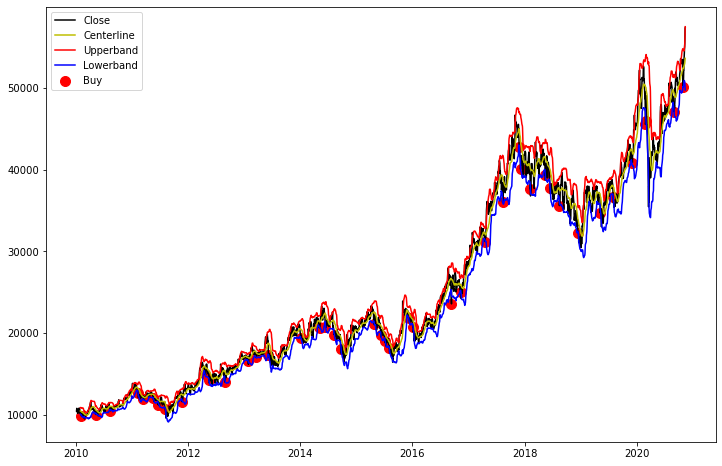

In [141]:
get_bollinger_band_back_testing_by_num("005935", "2010-01-01", num_buy=1)

In [142]:
def get_bollinger_band_back_testing_by_price(
    symbol:str="005930", 
    start_date:str=None, 
    end_date:str=None, 
    market:str="KRX", 
    price_buy:int=50000,
    day:int=20,
    alpha:int=2,
    fig_save_path:str=None):
    """
        볼린저 밴드: 
        중심선 = day일 종가 이동평균선 (defalt day=20)
        상한선 = 중심선 + alpha*(day일 종가 표준편차) (defalt day=20, defalt alpha=2)
        하한선 = 중심선 - alpha*(day일 종가 표준편차) (defalt day=20, defalt alpha=2)
        
        볼린저 밴드 하한선에 닿으면 지정된 한달 매수 금액에 맞게 매수를 진행.
        만약, 하한선에 닿지 않으면 다음 달로 이월하여 매수를 진행.
        
        symbol: 종목번호 혹은 종목티커
        start_date: 조회할 시작 날짜 (입력 안할 시 오늘로부터 30일 이전으로 설정됨)
        start_date: 조회할 끝 날짜 (입력 안할 시 오늘로 설정됨)
        market: KRX (KOSPI, KODAQ, KONEX), NASDAQ, NYSE, AMEX, S&P 500
        price_buy: 한달 매수 금액
        fig_save_path: 그래프 저장 경로 (확장자명은 생략)
    """
    name = get_name(symbol, market)
    
    if start_date is None:
        start_date = datetime.datetime.now()
        start_date = start_date - datetime.timedelta(days=30)
        start_date = datetime.datetime.strftime(start_date, "%Y-%m-%d")
        
    if end_date is None:
        end_date = datetime.datetime.now()
        end_date = datetime.datetime.strftime(end_date, "%Y-%m-%d")
        
    is_exsists, df = get_exists_excel(symbol, start_date, end_date)
    if not is_exsists:
        df = fdr.DataReader(symbol, start=start_date, end=end_date)
        save_excel(df, symbol, start_date, end_date)
        
    df["M20"] = df["Close"].rolling(day).mean()
    df["std"] = df["Close"].rolling(day).std()
    df["HighLine"] = df["M20"] + df["std"] * alpha
    df["LowLine"] = df["M20"] - df["std"] * alpha
        
    cond = df["Close"] <= df["LowLine"]
    close_cond = df.loc[cond, "Close"]
    try:
        current_price = df["Close"].iloc[-1]
        is_data = True
    except IndexError:
        is_data = False
    
    if is_data:
        buy_dict = dict()
        scatter_data = dict()
        for date, close in close_cond.items():
            _date = "_".join([str(date.year), str(date.month)]) # 2020_10 year_month
            if _date not in buy_dict:
                buy_dict[_date] = close
                scatter_data[date] = close

        date_list = list(buy_dict.keys())
        close_list = list(buy_dict.values())
        _start_date = start_date[:7].replace("-", "_")

        bought_dict = {"종목명": name, "종목코드": symbol, "보유수량": 0, "매입금액": 0}

        save_dif_month = 0
        new_scatter_data = dict()
        not_scatter_data = dict() # 돈 부족으로 매수 못한 데이터를 scatter
        scatter_data_date_list = list(scatter_data.keys())
        scatter_data_close_list = list(scatter_data.values())

        for idx in range(len(close_list)):
            date = date_list[idx]

            if idx == 0:
                before_date = _start_date
            else:
                before_date = date_list[idx-1]

            year = int(date.split("_")[0])
            month = int(date.split("_")[1])
            before_year = int(before_date.split("_")[0])
            before_month = int(before_date.split("_")[1])

            dif_year = year - before_year
            dif_month = month - before_month

            if save_dif_month == 0:
                dif_month = dif_year * 12 + dif_month
            elif save_dif_month != 0:
                dif_month = dif_year * 12 + dif_month + save_dif_month

            num_buy = (price_buy//close_list[idx])

            if num_buy != 0:
                bought_dict["보유수량"] += dif_month*num_buy
                bought_dict["매입금액"] += dif_month*num_buy*close_list[idx]
                key_date = scatter_data_date_list[idx]
                new_scatter_data[key_date] = scatter_data_close_list[idx]
                save_dif_month = 0
            else:
                save_dif_month += dif_month
                key_date = scatter_data_date_list[idx]
                not_scatter_data[key_date] = scatter_data_close_list[idx]

        try:        
            bought_dict["평균단가"] = int(bought_dict["매입금액"]/bought_dict["보유수량"])
            bought_dict["현재가"] = current_price
            bought_dict["수익률"] = round((bought_dict["현재가"]-bought_dict["평균단가"])/bought_dict["평균단가"]*100, 2)
            bought_dict["평가손익"] = int(bought_dict["매입금액"]*bought_dict["수익률"]/100)
            is_buy = True
        except ZeroDivisionError:
            is_buy = False

        if is_buy: # 그래프와 결과를 출력
            fig = plt.figure(figsize=(12, 8))
            plt.plot(df.index, df["Close"], color="k", label="Close")
            plt.plot(df.index, df["M20"], color="y", label="Centerline")
            plt.plot(df.index, df["HighLine"], color="r", label="Upperband")
            plt.plot(df.index, df["LowLine"], color="b", label="Lowerband")
            plt.scatter(new_scatter_data.keys(), new_scatter_data.values(), color="r", marker="o", label="Buy", s=100)
            plt.scatter(not_scatter_data.keys(), not_scatter_data.values(), color="g", marker="^", label="Not Buy", s=100)
            plt.legend()

            if fig_save_path is not None:
                if not osp.exists("results"):
                    os.mkdir("results")
                plt.savefig("results/{}.jpg".format(fig_save_path))

            for key, value in bought_dict.items():
                if key in ["종목명", "종목코드"]:
                    continue
                suffix = ""
                prefix = ""

                if key in ["매입금액", "평균단가", "현재가", "평가손익"]:
                    suffix = "원"

                elif key in ["보유수량"]:
                    suffix = "주"

                elif key in ["수익률"]:
                    suffix = "%"

                if key in ["수익률", "평가손익"]:
                    if value > 0:
                        prefix = "+"

                value = prefix+format(value, ",")+suffix
                bought_dict[key] = value
            return bought_dict

        else:
            print("매수가 일어나지 않았습니다.")
    
    else:
        print("데이터가 없습니다.")

{'종목명': '삼성전자',
 '종목코드': '005930',
 '보유수량': '11주',
 '매입금액': '503,050원',
 '평균단가': '45,731원',
 '현재가': '63,200원',
 '수익률': '+38.2%',
 '평가손익': '+192,165원'}

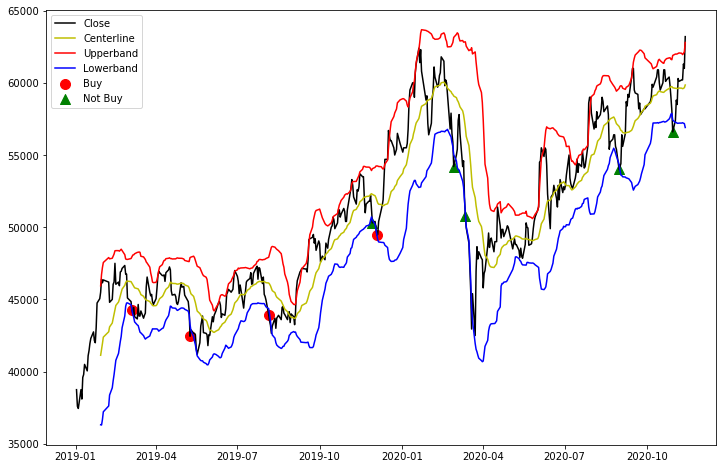

In [143]:
get_bollinger_band_back_testing_by_price("005930", "2019-01-01", price_buy=50000)